**Importing Libray's**

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading Dataset in **Pandas**

In [ ]:
brain_df = pd.read_csv('/content/drive/MyDrive/Brain Tumor_for pandas.csv',usecols=[0,1])
brain_df.head()

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


**Closer Insights About Dataset**

In [ ]:
brain_df.isna().sum()


Image    0
Class    0
dtype: int64

**Checking Imbalance**

In [ ]:
brain_df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

**Some Data Visualisation**

In [ ]:
path_list = []
base_path = '/content/drive/MyDrive/Brain Tumor/Brain Tumor'
for entry in os.listdir(base_path):
    path_list.append( os.path.join(base_path,entry))

In [ ]:
#create path dictonary and then map itto brain_df['pathes']
pathes_dict={os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
brain_df['pathes'] = brain_df['Image'].map(pathes_dict.get)

In [ ]:
brain_df.head()

,Image,Class,pathes
0,Image1,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...
1,Image2,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...
2,Image3,1,/content/drive/MyDrive/Brain Tumor/Brain Tumor...
3,Image4,1,/content/drive/MyDrive/Brain Tumor/Brain Tumor...
4,Image5,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...


**Plot some Examples from Dataset**

<ipython-input-9-c413401e5711>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,x+1)


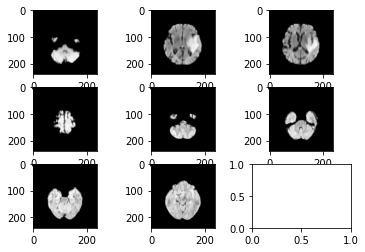

In [ ]:
for x in range (0 ,9):
    img = imread(brain_df['pathes'][x])
    plt.imshow(img)
    plt.subplot(3,3,x+1)

In [ ]:
from PIL.Image import open
brain_df['pixels']=brain_df['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))

In [ ]:
brain_df.head()

,Image,Class,pathes,pixels
0,Image1,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


# CLASSIFICATION USING BigDL

**Environment Preparation**

In [ ]:
!pip install --pre --upgrade bigdl-dllib-spark3

exit() # restart the runtime to refresh installed pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 23.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.3-py2.py3-none-any.whl size=214463484 sha256=b13d3501446c51ff259a9927a28b1e9cb2e2cc51768fa2c1f136b6e96ae32e22
  Stored in directory: /root/.cache/pip/wheels/d7/e1/24/93d2e871b4207bbe937e79953c5c93ee0183d26c2fce107ec5
Successfully built pyspark


#### **Step 0: Intialization** 

import necessary libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

Init NNContext and create Spark session

In [ ]:
ZooContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

Current pyspark location is : /usr/local/lib/python3.9/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.9/dist-packages/bigdl/share/core/lib/all-2.3.0-20221216.060121-1.jar:/usr/local/lib/python3.9/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.3-2.3.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


#### **Step 1: Load the data** 

we have used a brain tumor feature dataset including five first-order features and eight texture features with the target level (in the column Class).

- First Order Features

  - Mean
  - Variance
  - Standard Deviation
  - Skewness
  - Kurtosis

- Second Order Features

  - Contrast
  - Energy
  - ASM (Angular second moment)
  - Entropy
  - Homogeneity
  - Dissimilarity
  - Correlation
  - Coarseness </br>

Image column defines image name and Class column defines either the image has tumor or not (1 = Tumor, 0 = Non-Tumor)


**DLlib supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization** 

##### **Load the data into Spark DataFrame using Spark API**


In [ ]:
path='/content/drive/MyDrive/Brain Tumor.csv'
df = spark.read.csv(path, sep=',', inferSchema=True).toDF("Class","Mean","Variance","Standard Deviation","Entropy","Skweness","Kurtosis","Contrast","Energy","ASM","Homogenity","Diss","Corr","Coars")

In [ ]:
df.show(5)

+-----+-----------+-----------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+
|Class|       Mean|   Variance|Standard Deviation|    Entropy|   Skweness|   Kurtosis|   Contrast|     Energy|        ASM| Homogenity|       Diss|       Corr|    Coars|
+-----+-----------+-----------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+
|    0|6.535339355|619.5878446|       24.89152154|0.109059009|4.276477026|18.90057479|98.61397059|0.293314497|0.086033394|0.530941132|4.473345588|0.981938697|7.46E-155|
|    0|8.749969482| 805.957634|       28.38939298|0.266538307|3.718115626|14.46461754|63.85881588|0.475051296|0.225673734|0.651352027|3.220071568|0.988834396|7.46E-155|
|    1|7.341094971|1143.808219|       33.82023387|0.001466811|5.061750412|26.47956316|81.86720593|0.031916712|0.001018677|0.268274889|5.981799798|0.9780136

#### **Step 2: Process data using Spark DataFrame API** 


In [ ]:
vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["Mean","Variance","Standard Deviation","Entropy","Skweness","Kurtosis","Contrast","Energy","ASM","Homogenity","Diss","Corr","Coars"])
train_df = vecAssembler.transform(df)

In [ ]:
train_df.show()

+-----+-----------+-----------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+--------------------+
|Class|       Mean|   Variance|Standard Deviation|    Entropy|   Skweness|   Kurtosis|   Contrast|     Energy|        ASM| Homogenity|       Diss|       Corr|    Coars|            features|
+-----+-----------+-----------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+--------------------+
|    0|6.535339355|619.5878446|       24.89152154|0.109059009|4.276477026|18.90057479|98.61397059|0.293314497|0.086033394|0.530941132|4.473345588|0.981938697|7.46E-155|[6.535339355,619....|
|    0|8.749969482| 805.957634|       28.38939298|0.266538307|3.718115626|14.46461754|63.85881588|0.475051296|0.225673734|0.651352027|3.220071568|0.988834396|7.46E-155|[8.749969482,805....|
|    1|7.341094971|1143.808219|       33.82023387|

In [ ]:
changedTypedf = train_df.withColumn("label", train_df["class"].cast(DoubleType())+lit(1))\
    .select("features", "label")

In [ ]:
changedTypedf.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[6.535339355,619....|  1.0|
|[8.749969482,805....|  1.0|
|[7.341094971,1143...|  2.0|
|[5.958145142,959....|  2.0|
|[7.315231323,729....|  1.0|
|[7.524108887,607....|  1.0|
|[12.30441284,922....|  1.0|
|[15.92947388,1069...|  1.0|
|[19.9216156,1166....|  1.0|
|[8.476196289,1095...|  2.0|
|[9.804611206,1114...|  2.0|
|[12.32678223,1150...|  2.0|
|[10.19346619,813....|  2.0|
|[7.156311035,413....|  1.0|
|[5.291473389,430....|  1.0|
|[12.77394104,988....|  2.0|
|[15.31752014,1076...|  2.0|
|[6.24671936,459.3...|  1.0|
|[5.450424194,337....|  1.0|
|[8.333740234,475....|  1.0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
(trainingDF, validationDF) = changedTypedf.randomSplit([0.9, 0.1])

#### **Step 3: Define model using DLlib Keras-style API** 


In [ ]:
x1 = Input(shape=(13,))
dense1 = Dense(14, activation='relu')(x1)
dense2 = Dense(8, activation='relu')(dense1)
dense3 = Dense(2)(dense2)
model = Model(x1, dense3)

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel


#### **Step 4: Create NNClassifier**

In [ ]:
classifier = NNClassifier(model, CrossEntropyCriterion(), [13]) \
    .setOptimMethod(Adam()) \
    .setBatchSize(32) \
    .setMaxEpoch(150)

creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createAdam


In [ ]:
nnModel = classifier.fit(trainingDF)

Streaming output truncated to the last 5000 lines.
2023-03-17 13:20:47.600 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 104 1888/3397][Iteration 11080][Wall Clock 473.370440274s] Trained 32.0 records in 0.031326173 seconds. Throughput is 1021.50995 records/second. Loss is 0.021667957. 
2023-03-17 13:20:47.625 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 104 1920/3397][Iteration 11081][Wall Clock 473.394506528s] Trained 32.0 records in 0.024066254 seconds. Throughput is 1329.6627 records/second. Loss is 0.47677106. 
2023-03-17 13:20:47.649 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 104 1952/3397][Iteration 11082][Wall Clock 473.417911687s] Trained 32.0 records in 0.023405159 seconds. Throughput is 1367.22 records/second. Loss is 0.099491656. 
2023-03-17 13:20:47.674 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - [Epoch 104 1984/3397][Iteration 11083][W

#### **Step 5: Evaluate the trained model**


In [ ]:
predictionDF = nnModel.transform(validationDF).cache()
predictionDF.sample(False, 0.1).show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionDF)

print("Accuracy = %g " % (accuracy))

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[1.640151978,171....|  2.0|       2.0|
|[1.814300537,167....|  2.0|       2.0|
|[1.850891113,86.1...|  1.0|       1.0|
|[2.23248291,300.8...|  2.0|       2.0|
|[3.190841675,192....|  1.0|       1.0|
|[3.840316772,454....|  2.0|       2.0|
|[4.024093628,262....|  1.0|       2.0|
|[4.199081421,400....|  1.0|       1.0|
|[5.054000854,315....|  1.0|       1.0|
|[5.641723633,302....|  1.0|       1.0|
|[5.73324585,361.5...|  1.0|       1.0|
|[5.835174561,570....|  2.0|       2.0|
|[6.41003418,884.2...|  2.0|       2.0|
|[6.544784546,1103...|  2.0|       2.0|
|[6.660293579,518....|  1.0|       1.0|
|[6.83152771,926.1...|  2.0|       2.0|
|[6.841491699,449....|  1.0|       1.0|
|[7.328918457,415....|  1.0|       1.0|
|[7.335006714,726....|  2.0|       2.0|
|[7.347702026,494....|  2.0|       2.0|
+--------------------+-----+----------+
only showing top 20 rows

Accuracy = 0.9